# Import libraries

In [1]:
import pandas as pd
from torch.utils.data import DataLoader
from dataset import NCFDataset
from helpers.dataloader_custom_functions import collate_fn
from recom_ncf import NCFRecommender
from evaluation import Evaluation
from helpers.index_manager import IndexManager
from tuner import NCFTuner

# Loading data

In [2]:
df_train = pd.read_csv('../data/train-leave2.csv')
df_val = pd.read_csv('../data/val-leave2.csv')
df_test = pd.read_csv('../data/test-leave2.csv')
index_manager = IndexManager()
index_manager.load('../data/index.pkl')

# Tuning model

In [3]:
unique_users = index_manager.get_indexed_values('user_id')
unique_items = index_manager.get_indexed_values('item_id')

tuner = NCFTuner(
    train_data=df_train,
    val_data=df_val,
    test_data=df_test,
    unique_users=unique_users,
    unique_items=unique_items,
)

In [4]:
param_grid = {
            'factors': [8, 16, 32, 64],
            'mlp_user_item_dim': [32, 64, 128],
            'learning_rate': [0.0005, 0.001, 0.005],
            'epochs': [10, 20, 50],
            'optimizer': ['adagrad', 'adam', 'sgd'],
            'dropout': [0.0, 0.2, 0.5],
            'weight_decay': [0.0, 0.0001, 0.0005, 0.001],
            'loss_fn': ['bce', 'mse', 'bpr'],
            'batch_size': [8192, 16384],
}

tuner.set_param_grid(param_grid)

In [5]:
results, file_path = tuner.perform_random_search(num_trials=1)

Running experiment with params: {'factors': 64, 'mlp_user_item_dim': 128, 'learning_rate': 0.0005, 'epochs': 50, 'optimizer': 'sgd', 'dropout': 0.0, 'weight_decay': 0.0, 'loss_fn': 'bpr', 'batch_size': 8192}
Epoch 1/50
Train loss: 0.691881, Validation loss: 0.690662
Epoch 2/50
Train loss: 0.686465, Validation loss: 0.687401
Epoch 3/50
Train loss: 0.681212, Validation loss: 0.684265
Epoch 4/50
Train loss: 0.676109, Validation loss: 0.681248
Epoch 5/50
Train loss: 0.671150, Validation loss: 0.678346
Epoch 6/50
Train loss: 0.666330, Validation loss: 0.675555
Epoch 7/50
Train loss: 0.661649, Validation loss: 0.672873
Epoch 8/50
Train loss: 0.657093, Validation loss: 0.670294
Epoch 9/50
Train loss: 0.652671, Validation loss: 0.667815
Epoch 10/50
Train loss: 0.648368, Validation loss: 0.665435
Epoch 11/50
Train loss: 0.644185, Validation loss: 0.663148
Epoch 12/50
Train loss: 0.640121, Validation loss: 0.660953
Epoch 13/50
Train loss: 0.636167, Validation loss: 0.658846
Epoch 14/50
Train los

In [6]:
best_params = tuner.analyze_results()
print("Best parameters:", best_params)

Best parameters: {'Hit Ratio@10': {'params': {'factors': 64, 'mlp_user_item_dim': 128, 'learning_rate': 0.0005, 'epochs': 50, 'optimizer': 'sgd', 'dropout': 0.0, 'weight_decay': 0.0, 'loss_fn': 'bpr', 'batch_size': 8192}, 'value': 0.00013970842030867342}, 'NDCG@10': {'params': {'factors': 64, 'mlp_user_item_dim': 128, 'learning_rate': 0.0005, 'epochs': 50, 'optimizer': 'sgd', 'dropout': 0.0, 'weight_decay': 0.0, 'loss_fn': 'bpr', 'batch_size': 8192}, 'value': 5.712395504532194e-05}, 'Recall@10': {'params': {'factors': 64, 'mlp_user_item_dim': 128, 'learning_rate': 0.0005, 'epochs': 50, 'optimizer': 'sgd', 'dropout': 0.0, 'weight_decay': 0.0, 'loss_fn': 'bpr', 'batch_size': 8192}, 'value': 0.00013970842030867342}}


# Analyzing results

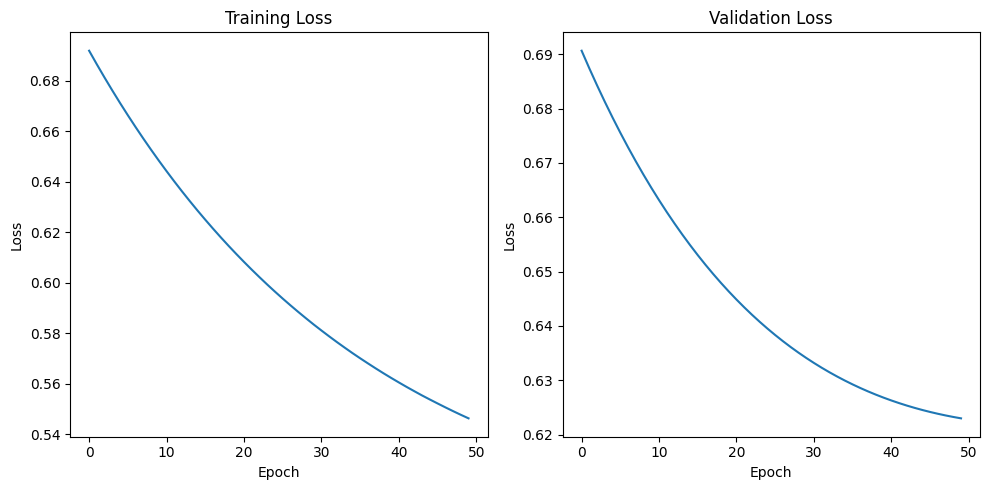

In [7]:
df_result = tuner.plot_results()

In [8]:
df_result

,factors,mlp_user_item_dim,learning_rate,epochs,optimizer,dropout,weight_decay,loss_fn,batch_size,Hit Ratio@10,NDCG@10,Recall@10
0,64,128,0.0005,50,sgd,0.0,0.0,bpr,8192,0.00014,0.000057,0.00014


# Train model with best params

In [9]:
best_param = best_params['Hit Ratio@10']['params']

train_dataset = NCFDataset(df_train)
val_dataset = NCFDataset(df_val)

dataloader_params = {
    'batch_size': best_param.pop('batch_size', 8192),
    'num_workers': 4,
    'persistent_workers': True,
    'prefetch_factor': 4,
    'pin_memory': True,
    'collate_fn': collate_fn
}

train_dataloader = DataLoader(train_dataset, shuffle=True, **dataloader_params)
eval_dataloader = DataLoader(val_dataset, shuffle=False, **dataloader_params)

model = NCFRecommender(unique_users, unique_items, **best_param)
model.fit(train_dataloader, eval_dataloader)

evaluator = Evaluation(recommender=model, test_data=df_test)
metrics = evaluator.evaluate()

Epoch 1/50
Train loss: 0.875673, Validation loss: 0.817524
Epoch 2/50
Train loss: 0.874387, Validation loss: 0.816297
Epoch 3/50
Train loss: 0.873100, Validation loss: 0.815073
Epoch 4/50
Train loss: 0.871821, Validation loss: 0.813853
Epoch 5/50
Train loss: 0.870532, Validation loss: 0.812637
Epoch 6/50
Train loss: 0.869254, Validation loss: 0.811425
Epoch 7/50
Train loss: 0.867984, Validation loss: 0.810217
Epoch 8/50
Train loss: 0.866719, Validation loss: 0.809012
Epoch 9/50
Train loss: 0.865456, Validation loss: 0.807812
Epoch 10/50
Train loss: 0.864182, Validation loss: 0.806615
Epoch 11/50
Train loss: 0.862926, Validation loss: 0.805423
Epoch 12/50
Train loss: 0.861682, Validation loss: 0.804234
Epoch 13/50
Train loss: 0.860414, Validation loss: 0.803050
Epoch 14/50
Train loss: 0.859195, Validation loss: 0.801869
Epoch 15/50
Train loss: 0.857949, Validation loss: 0.800693
Epoch 16/50
Train loss: 0.856708, Validation loss: 0.799521
Epoch 17/50
Train loss: 0.855480, Validation loss

In [10]:
for metric in metrics.keys():
    print(f'{metric}:\t{metrics[metric]: .7f}')

Hit Ratio@10:	 0.0001726
NDCG@10:	 0.0000852
Recall@10:	 0.0001726
